## POOL mAMZN_UST

Modification2 (Add dsw_oracle fallback_window_size=48h)
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- FALLBACK_WINDOW_SIZE = 48h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [16]:
EXPERIMENT_ID = 85

X_NAME = 'mAMZN'
Y_NAME = 'UST'

WINDOW_SIZE = 24 * 60 * 60

In [17]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [18]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [19]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [20]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [21]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,1,UST,mAMZN,2350.000000,0.0,0.721070,9.400000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,598,2020-12-03 19:08:19,2020-12-03 19:08:10,0xf5c5766c2684fdd0997bf77520eb59828466e17f263b...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xf53cab0c6f25f48f985d1e2c40e03fc7c1963364,1,96.964393,310524.777000,3.010985e+07,0,0,False,96.243323,312865.377000,3.011120e+07,0,0,False,3250.774881,0.015086
1,2,UST,mAMZN,4300.000000,0.0,1.291955,17.200000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,602,2020-12-03 19:09:19,2020-12-03 19:09:07,0xb10cd689a829a7e356b73596d6fca504a11421d9387f...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x4add3b2277e1a79e4cf6b52ccb26b2c80b37f142,2,96.243323,312865.377000,3.011120e+07,0,0,False,94.951368,317148.177000,3.011365e+07,195046,0,False,3340.111716,0.027482
2,5,UST,mAMZN,2884.657644,0.0,0.847528,11.538631,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,633,2020-12-03 19:17:04,2020-12-03 19:16:53,0x746b2fc227338792f29f6f22f4c5e06f21a12183e973...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xdec08cb92a506b88411da9ba290f3694be223c26,5,96.978358,323920.113240,3.141324e+07,195046,0,False,96.130830,326793.232253,3.141490e+07,1748205,0,False,3399.463355,0.017764
3,6,mAMZN,UST,0.400000,0.0,1340.664773,5.362659,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,652,2020-12-03 19:21:49,2020-12-03 19:21:42,0x215b96593f26c2b770b98fa8c89ad72585395c5cd994...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xdec08cb92a506b88411da9ba290f3694be223c26,6,96.130830,326793.232253,3.141490e+07,1748205,0,False,96.530830,325447.204821,3.141569e+07,2717052,0,False,3371.432800,-0.008246
4,7,mAMZN,UST,0.400000,0.0,1329.632814,5.318531,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,655,2020-12-03 19:22:34,2020-12-03 19:22:29,0x7d96885b515444001a8d60e19fc600aab4cafcf1ab54...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xdec08cb92a506b88411da9ba290f3694be223c26,7,96.530830,325447.204821,3.141569e+07,2717052,0,False,96.930830,324112.253476,3.141647e+07,2868767,0,False,3343.747857,-0.008212


In [22]:
swaps0_df.status.value_counts()

SUCCESS    1626
Name: status, dtype: int64

In [23]:
swaps1_df.status.value_counts()

SUCCESS    1626
Name: status, dtype: int64

In [24]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.0


In [25]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                1608
CANT_CONSULT_ORACLE      18
Name: mitigator_check_status, dtype: int64

In [26]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.01107011070110701


In [27]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    214
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    214
Name: status, dtype: int64


**0** have been **blocked by the volatility mitigation mechanism**. In only 1.1% of the cases volatility mitigation mechanism didn't check the transaction because of the missing observations in the DSW oracle (81% without modification)

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

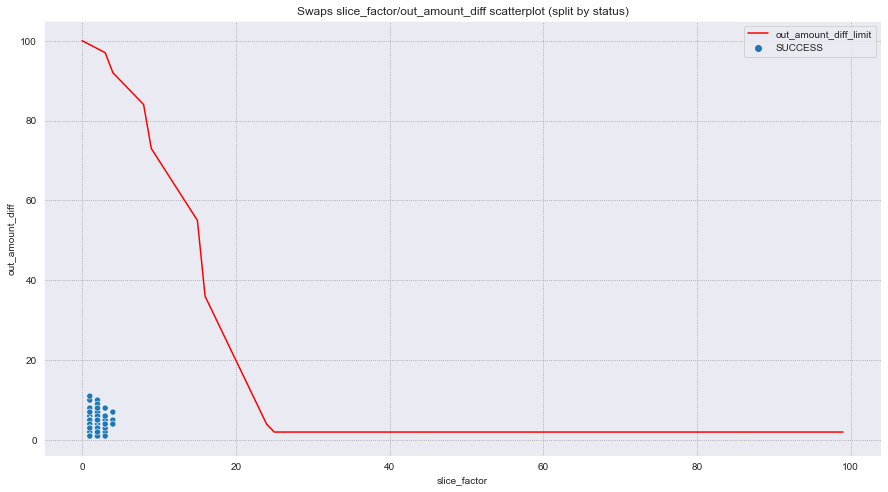

In [36]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

**It can be seen that there are more observations than in the initial version, as the volatility mitigation checked much more transactions because of the TWAP availability.**

In [29]:
swaps0_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,1,UST,mAMZN,2350.000000,0.0,0.721070,9.400000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,598,2020-12-03 19:08:19,2020-12-03 19:08:10,0xf5c5766c2684fdd0997bf77520eb59828466e17f263b...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xf53cab0c6f25f48f985d1e2c40e03fc7c1963364,1,96.964393,3.105248e+05,3.010985e+07,0,0,False,96.243323,3.128654e+05,3.011120e+07,0,0,False,3250.774881,1.508619e-02
1,2,UST,mAMZN,4300.000000,0.0,1.291955,17.200000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,602,2020-12-03 19:09:19,2020-12-03 19:09:07,0xb10cd689a829a7e356b73596d6fca504a11421d9387f...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x4add3b2277e1a79e4cf6b52ccb26b2c80b37f142,2,96.243323,3.128654e+05,3.011120e+07,0,0,False,94.951368,3.171482e+05,3.011365e+07,195046,0,False,3340.111716,2.748170e-02
2,5,UST,mAMZN,2884.657644,0.0,0.847528,11.538631,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,633,2020-12-03 19:17:04,2020-12-03 19:16:53,0x746b2fc227338792f29f6f22f4c5e06f21a12183e973...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xdec08cb92a506b88411da9ba290f3694be223c26,5,96.978358,3.239201e+05,3.141324e+07,195046,0,False,96.130830,3.267932e+05,3.141490e+07,1748205,0,False,3399.463355,1.776444e-02
3,6,mAMZN,UST,0.400000,0.0,1340.664773,5.362659,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,652,2020-12-03 19:21:49,2020-12-03 19:21:42,0x215b96593f26c2b770b98fa8c89ad72585395c5cd994...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xdec08cb92a506b88411da9ba290f3694be223c26,6,96.130830,3.267932e+05,3.141490e+07,1748205,0,False,96.530830,3.254472e+05,3.141569e+07,2717052,0,False,3371.432800,-8.245582e-03
4,7,mAMZN,UST,0.400000,0.0,1329.632814,5.318531,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,655,2020-12-03 19:22:34,2020-12-03 19:22:29,0x7d96885b515444001a8d60e19fc600aab4cafcf1ab54...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xdec08cb92a506b88411da9ba290f3694be223c26,7,96.530830,3.254472e+05,3.141569e+07,2717052,0,False,96.930830,3.241123e+05,3.141647e+07,2868767,0,False,3343.747857,-8.211625e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,2205,UST,mAMZN,0.175045,0.0,0.000047,0.000700,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2037772,2021-11-22 11:21:49,2021-11-22 11:21:44,0xd6e9be6171f0fd526b15d373767e4695302d36037443...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x8ae48a768f8270e8349f2d4f1511311a1143e9ed,2205,1917.829315,7.102934e+06,1.362221e+10,103007992828,9086,False,1917.829268,7.102934e+06,1.362221e+10,103013214949,9087,False,3703.632032,4.894309e-08
1622,2207,mAMZN,UST,10.989001,0.0,40064.949374,160.259797,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2038681,2021-11-22 15:09:04,2021-11-22 15:08:58,0x48c20eca5b2fba7e0fe38f96bffe9d76f3fd3dd7c070...,0x1111111254fb6c44bac0bed2854e76f90643097d,0x5690df030163680f4da2046798614c3f5c24f64a,2207,1917.829315,7.102934e+06,1.362222e+10,103013214949,9087,False,1928.818315,7.062709e+06,1.362268e+10,103063713972,9090,False,3661.676591,-1.132819e-02
1623,2210,UST,mAMZN,25000.000000,0.0,6.735380,100.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2050330,2021-11-24 15:41:19,2021-11-24 15:41:08,0xf5f03b8ddad1286f17c534edc42f9db3d29499dc2aa6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x657e21723ae99c05c9c2a6032343c7865bcb1940,2210,1941.997176,7.111362e+06,1.381025e+10,103063713972,9090,False,1935.261796,7.136262e+06,1.381054e+10,103703572705,9138,False,3687.491840,6.993971e-03
1624,2211,mAMZN,UST,8.857576,0.0,32189.759555,128.759038,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,20

Text(0, 0.5, 'Count')

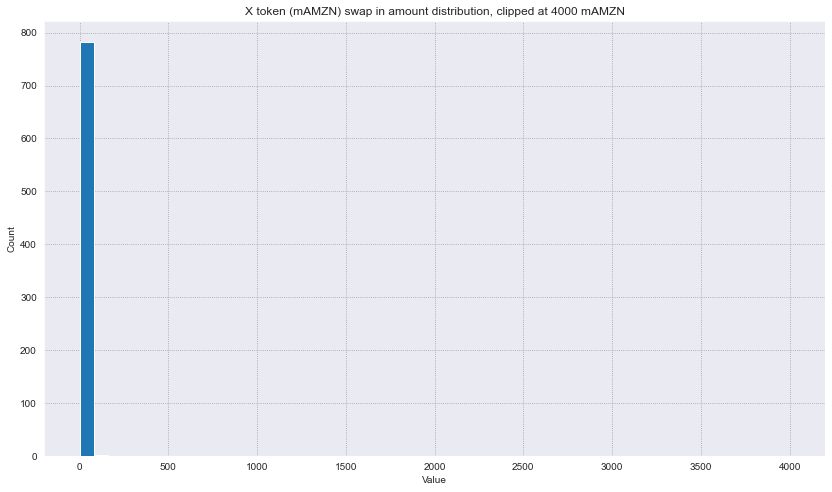

In [30]:
UPPER_LIMIT = 4000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

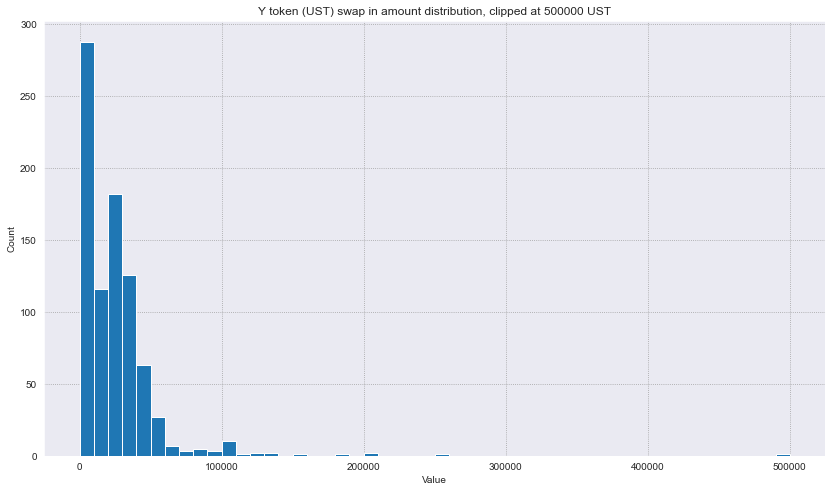

In [31]:
UPPER_LIMIT = 500000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

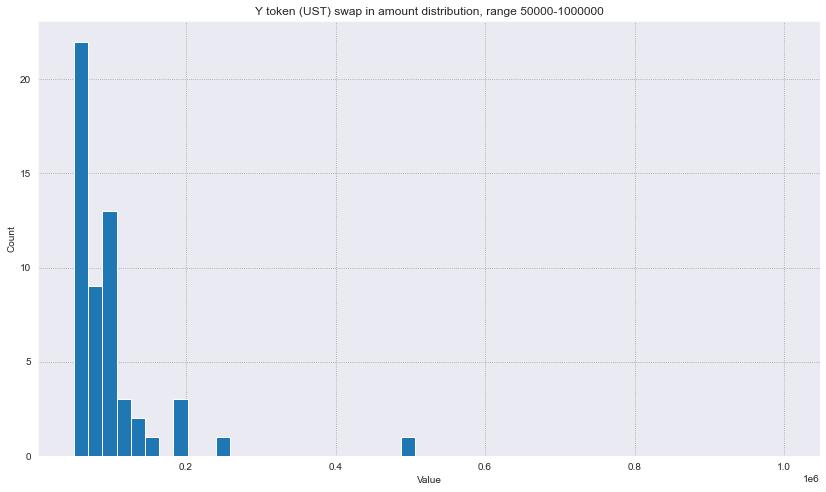

In [32]:
LOWER_LIMIT = 50000
UPPER_LIMIT = 1000000
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

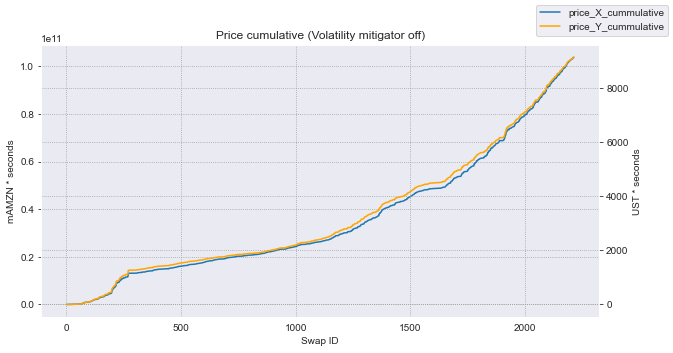

In [33]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps0_df.id, swaps0_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

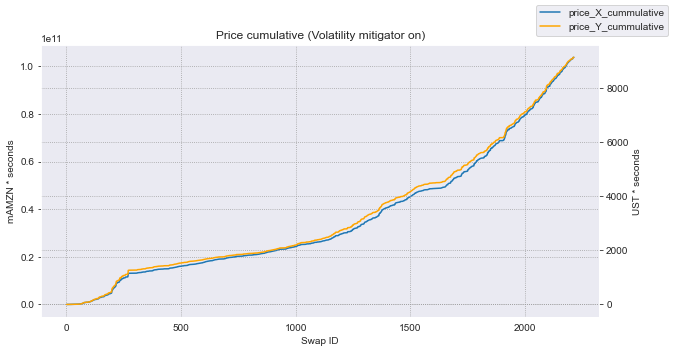

In [34]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

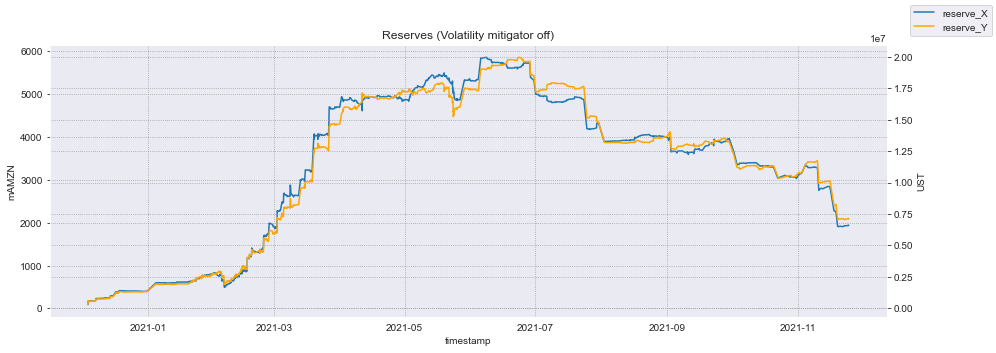

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

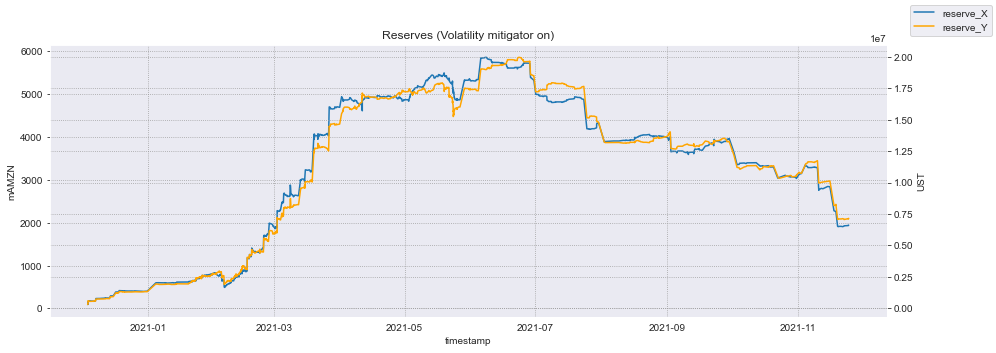

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

**The variation of reserves over time is very similar at the first glance with and without the volatility mitigator**

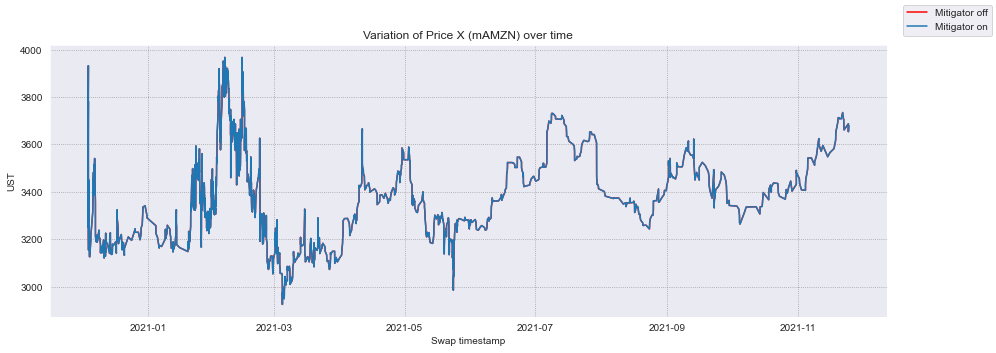

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**The variation of price is the same as in the initial version**

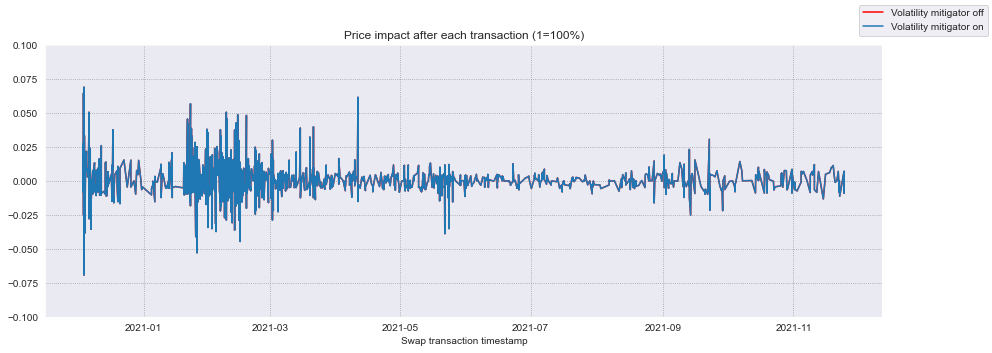

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-0.1, 0.1)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

In [26]:
swaps1_df[swaps1_df.price_diff > 0.1]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff


In [27]:
swaps1_df.iloc[615:623]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
615,866,UST,mAMZN,18977.000000,0.0,5.432554,75.908000,CHECKED,5.387127,NaN,NaN,NaN,SUCCESS,432607,2021-02-16 19:10:34,2021-02-16 19:10:28,0x66ae7a8bc9d510d651a8e73238755632918b424d2ece...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x657e21723ae99c05c9c2a6032343c7865bcb1940,866,1169.168919,4.024512e+06,4.705335e+09,21492014256,1943,True,1163.736365,4.043413e+06,4.705467e+09,21590168568,1951,True,3474.509875,0.009387
616,868,mAMZN,UST,2.925726,0.0,10039.019129,40.156077,CHECKED,10195.667824,1.0,1.0,1.0,SUCCESS,434231,2021-02-17 01:56:34,2021-02-17 01:56:24,0x7cbbdfd83876ae5212447d8f13c5820c333e841633f9...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xfc41cc8340320d6ebdb3b64149c1fbc8f0295361,868,1169.188866,4.062391e+06,4.749702e+09,21590168568,1951,True,1172.114592,4.052311e+06,4.749773e+09,21674808300,1958,True,3457.265487,-0.004971
617,871,mAMZN,UST,4.505469,0.0,15361.327263,61.445309,CHECKED,15873.398579,3.0,1.0,1.0,SUCCESS,435601,2021-02-17 07:39:04,2021-02-17 07:38:55,0xb627f9a408bb1e7bd7cd9774f145d75b9f70bacdb5d2...,0xe069cb01d06ba617bcdf789bf2ff0d5e5ca20c71,0xe069cb01d06ba617bcdf789bf2ff0d5e5ca20c71,871,1157.639100,4.002182e+06,4.633083e+09,21674808300,1958,True,1162.144569,3.986759e+06,4.633191e+09,21745853623,1964,True,3430.519318,-0.007716
618,873,mAMZN,UST,4.322546,0.0,14632.023200,58.528093,CHECKED,15195.058775,3.0,1.0,1.0,SUCCESS,436534,2021-02-17 11:32:19,2021-02-17 11:32:12,0x6057b91353126e5755f40a5c91163f40f361089d78f9...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x80a245441044f3e28812a340138eab1794578bf3,873,1252.054569,4.295707e+06,5.378459e+09,21745853623,1964,True,1256.377115,4.281016e+06,5.378571e+09,21793869436,1968,True,3407.429395,-0.006849
619,874,mAMZN,UST,3.800272,0.0,12781.392569,51.125570,CHECKED,13356.473135,4.0,1.0,1.0,SUCCESS,436605,2021-02-17 11:50:04,2021-02-17 11:49:56,0x516f37401030d8238ff46e98850bc9014be5631b7f49...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x80a245441044f3e28812a340138eab1794578bf3,874,1256.377115,4.281016e+06,5.378571e+09,21793869436,1968,True,1260.177387,4.268184e+06,5.378669e+09,21797498348,1969,True,3386.970627,-0.006004
620,876,mAMZN,UST,0.464644,0.0,1557.362823,6.229451,CHECKED,1609.427411,3.0,1.0,1.0,SUCCESS,439075,2021-02-17 22:07:34,2021-02-17 22:07:28,0x23047843f503b5707ffa20e6df963400210043a75773...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x16abe8e8c4bb84ae92492a2ae447fe507855eaf3,876,1231.389544,4.170537e+06,5.135555e+09,21797498348,1969,True,1231.854188,4.168973e+06,5.135567e+09,21922981290,1980,True,3384.307243,-0.000752
621,877,UST,mAMZN,100000.000000,0.0,28.574118,400.000000,CHECKED,29.016659,1.0,3.0,3.0,SUCCESS,440029,2021-02-18 02:06:04,2021-02-18 02:05:57,0x919e116410a89ea0f376c872c016ff0789af2157fd2a...,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x4125caf9dd93ec6ad7a4c668ec55102f8f18203a,877,1231.854188,4.168973e+06,5.135567e+09,21922981290,1980,True,1203.280070,4.268573e+06,5.136289e+09,21971410727,1984,True,3547.447645,0.048205
622,878,mAMZN,UST,12.374077,0.0,43019.454572,172.077818,CHECKED,42613.144293,NaN,NaN,NaN,SUCCESS,440034,2021-02-18 02:07:19,2021-02-18 02:07:05,0x1817d895a71e6eae3d0ad5b84384851cc087016fc0f0...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x80a245441044f3e28812a340138eab1794578bf3,878,1203.280070,4.268573e+06,5.136289e+09,21971410727,1984,True,1215.654147,4.225382e+06,5.136603e+09,21971676785,1984,True,3475.808912,-0.020194


**The price impact after each transaction doesn't exceed 0.25 and is the same as initially before the modification in the DSW oracle**